Through EDA, we know that we are given monthly data for 3135 counties each for 39 months. We need to predict the same for the next 8 months for each county.
We also know that trend varies greatly between counties and therefore we will need to predict separately for each county.
There is an yearly seasonality to the data.

### Importing Libraries

In [1]:
from tqdm.auto import tqdm
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline


/home/laksie98/opt/anaconda3/envs/av-prophet/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


**Read training data**

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


We only need county id, datetime and target variables

In [4]:
train_data = train[['cfips', 'first_day_of_month', 'microbusiness_density']]

In [5]:
train_data = train_data.astype({'cfips':'category', 'first_day_of_month':'datetime64[ns]'})

In [6]:
train_data.dtypes

cfips                          category
first_day_of_month       datetime64[ns]
microbusiness_density           float64
dtype: object

In [7]:
train_data.sort_values(by=['cfips', 'first_day_of_month'])

,cfips,first_day_of_month,microbusiness_density
0,1001,2019-08-01,3.007682
1,1001,2019-09-01,2.884870
2,1001,2019-10-01,3.055843
3,1001,2019-11-01,2.993233
4,1001,2019-12-01,2.993233
...,...,...,...
122260,56045,2022-06-01,1.803249
122261,56045,2022-07-01,1.803249
122262,56045,2022-08-01,1.785395
122263,56045,2022-09-01,1.785395


In [8]:
# List of all the counties
cfips = train_data['cfips'].unique()

#### Testing for a few counties

Try using facebook prophet on n random counties using the first 31 months for training

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


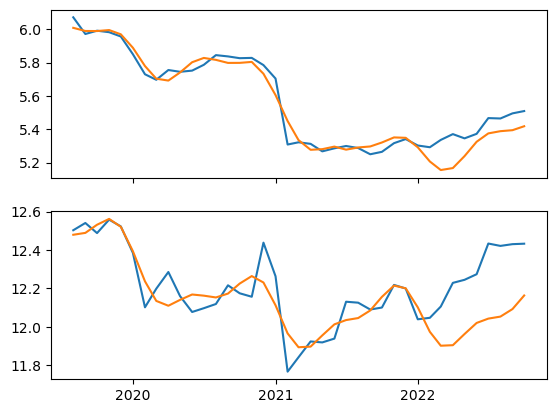

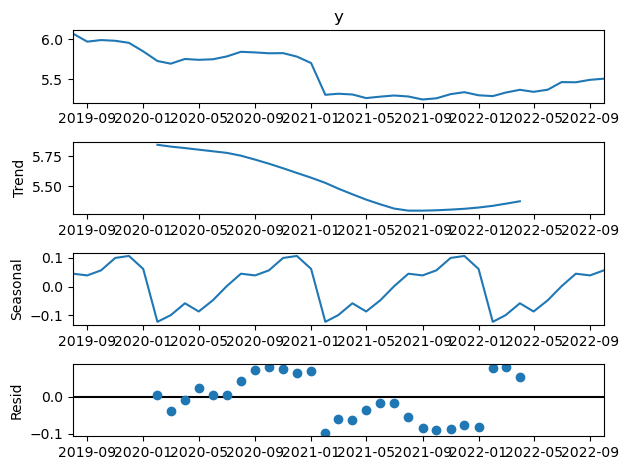

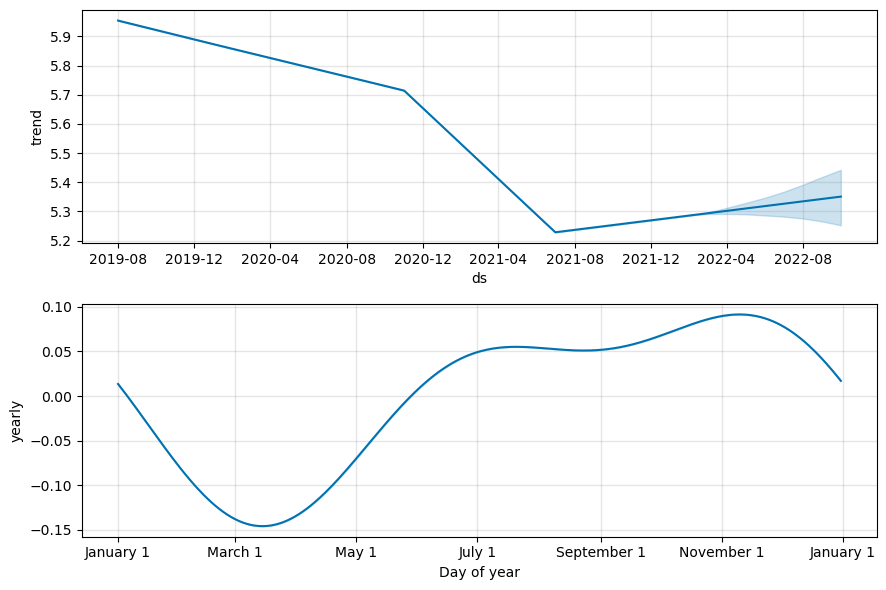

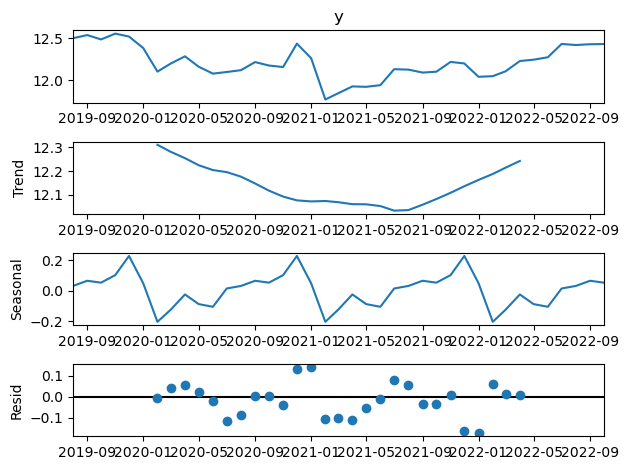

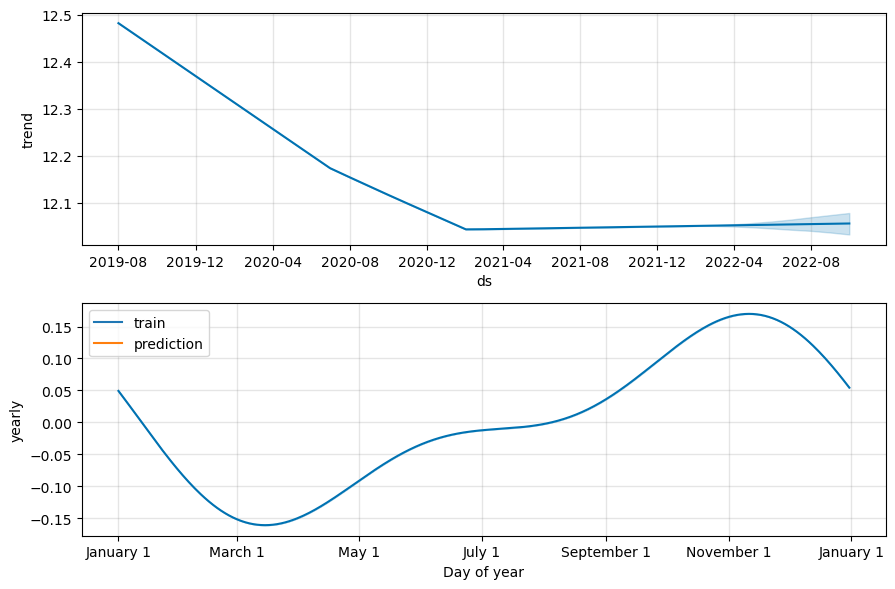

In [17]:
n = 2
fig, axs = plt.subplots(n, sharex='col')
for i in range(n):
    county = random.choice(cfips)
    prophet_data = train_data.loc[train_data['cfips']==county, ['first_day_of_month', 'microbusiness_density']]
    prophet_data.rename(
        columns={'first_day_of_month': 'ds', 'microbusiness_density': 'y'}, inplace=True)

    temp = prophet_data.copy()
    temp.set_index('ds', inplace=True)
    decom_data = seasonal_decompose(temp['y'])
    decom_data.plot()

    ax = axs[i]
    l1 = ax.plot(prophet_data['ds'].values, prophet_data['y'].values, label = 'train')
    prophet_data = prophet_data.iloc[:31]
    model = Prophet(yearly_seasonality=2)
    model.fit(prophet_data)
    future = model.make_future_dataframe(periods=8, freq = 'MS')
    forecast = model.predict(future)
    model.plot_components(forecast)
    l2 = ax.plot(forecast['ds'].values, forecast['yhat'].values, label = 'prediction')

    locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

lines_labels = [fig.axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

plt.legend(lines, labels)
plt.show()

In [18]:
forecast_dict = {}

def store(county, x, forecast_dict):
    forecast_dict[str(county)+'_'+str(x['date'])] = x['yhat']

for county in tqdm(cfips):

    prophet_data = train_data.loc[train_data['cfips'] == county, [
        'first_day_of_month', 'microbusiness_density']]
    prophet_data.rename(columns={'first_day_of_month': 'ds', 'microbusiness_density': 'y'}, inplace=True)
    model = Prophet(yearly_seasonality=2)
    model.fit(prophet_data)
    future = model.make_future_dataframe(periods=8, freq='MS')
    forecast = model.predict(future)
    forecast = forecast[39:][['ds', 'yhat']]
    forecast['date'] = forecast['ds'].dt.date
    forecast.apply(lambda x: store(county=county, x=x,
               forecast_dict=forecast_dict), axis=1)


 71%|███████   | 2231/3135 [1:02:26<25:23,  1.69s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 71%|███████   | 2232/3135 [1:02:28<26:42,  1.77s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 71%|███████   | 2233/3135 [1:02:30<25:47,  1.72s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 71%|███████▏  | 2234/3135 [1:02:32<26:16,  1.75s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily

In [19]:
forecast_dict

{'1001_2022-11-01': 3.4301505834434107,
 '1001_2022-12-01': 3.412360560286814,
 '1001_2023-01-01': 3.4188117165067946,
 '1001_2023-02-01': 3.451391265291483,
 '1001_2023-03-01': 3.488252208254295,
 '1001_2023-04-01': 3.5195850519807643,
 '1001_2023-05-01': 3.5373169057701097,
 '1001_2023-06-01': 3.5545376186382365,
 '1003_2022-11-01': 8.519961154937715,
 '1003_2022-12-01': 8.510022586044942,
 '1003_2023-01-01': 8.451017939078131,
 '1003_2023-02-01': 8.406288894026392,
 '1003_2023-03-01': 8.432760292964009,
 '1003_2023-04-01': 8.545529748886652,
 '1003_2023-05-01': 8.690040127490306,
 '1003_2023-06-01': 8.809393607693426,
 '1005_2022-11-01': 1.2373086033074925,
 '1005_2022-12-01': 1.2420261252363303,
 '1005_2023-01-01': 1.253002481866105,
 '1005_2023-02-01': 1.2698737637385253,
 '1005_2023-03-01': 1.2845247899553007,
 '1005_2023-04-01': 1.2933863901743445,
 '1005_2023-05-01': 1.2937137832237104,
 '1005_2023-06-01': 1.2916518368544667,
 '1007_2022-11-01': 1.3001877221957672,
 '1007_2022-

In [20]:
test = pd.read_csv('test.csv')

In [21]:
submission_prophet = pd.DataFrame()
submission_prophet['row_id'] = test['row_id']

In [22]:
submission_prophet.head()

,row_id
0,1001_2022-11-01
1,1003_2022-11-01
2,1005_2022-11-01
3,1007_2022-11-01
4,1009_2022-11-01


In [23]:
submission_prophet['microbusiness_density'] = submission_prophet['row_id'].apply(lambda x: forecast_dict[x])

In [24]:
submission_prophet.head()

,row_id,microbusiness_density
0,1001_2022-11-01,3.430151
1,1003_2022-11-01,8.519961
2,1005_2022-11-01,1.237309
3,1007_2022-11-01,1.300188
4,1009_2022-11-01,1.836782


In [25]:
submission_prophet.isnull().sum()

row_id                   0
microbusiness_density    0
dtype: int64

In [26]:
submission_prophet.to_csv('submission_prophet_seasonality_2.csv', index = False)

Kaggle SMAPE = 4.141